In [2]:
# Import python libraries

from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Define circuit parameters 

# Define number of fock states in resonator
N = 20

# Circuit parameters
wr = 7.062 * 2 * np.pi      # Resonator frequency (7.062 GHz)[from reference]
wq = 5.092 * 2 * np.pi      # Qubit frequency (5.092 GHz)[from reference]
delta = abs(wr - wq)        # Detuning between qubit and resonator (1.97 GHz)[from reference]
k = 0.00535 * 2 * np.pi     # Resonator decay rate (5.35 MHz)[from reference]
g = 0.1029 * 2 * np.pi      # Coupling strength (102.9 MHz)[from reference]
gamma = 0.001 * 2 * np.pi   # Qubit decay (1 MHz) [self-defined, not from reference]

wr_d = wr - g**2 / delta    # Dressed resonator frequency (9.9997 GHz)
wq_d = wq + g**2 / delta    # Dressed qubit frequency (5.0003 GHz)
wd = wr

alpha = 0.157 * 2 * np.pi   # Anharmonity (157 MHz) [Chosen to align results]
K = alpha * (g/delta)**4      # Kerr self-nonlinearity (8.18 KHz) [Derived from Yvonne reference]
chi = 2 * alpha * (g/delta)**2 # Dispersive shift, cross non-linearity (5.378 MHz) [Derived from Yvonne reference]

n_crit = (delta / 2*g)**2  # Critical photon number (16)

# Define quantum operators
a = tensor(destroy(N), qeye(2))    # Resonator lowering operator
q = tensor(qeye(N), destroy(2))    # Qubit lowering operator
# Define qubit Pauli operators in composite space
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

# Base Hamiltonian without drive (lab frame):
# H0 = wq * q.dag() * q + wr * a.dag() * a  - alpha/2 * q.dag() * q.dag() * q * q - K/2 * a.dag() * a.dag() * a * a - g * (a + a.dag()) * (q + q.dag())  # Dispersive Hamiltonian
# H0 = wq_d * sz/2 + wr_d * a.dag() * a - chi * a.dag() * a * sz  # Dispersive Hamiltonian

# H0 = wq * q.dag() * q + wr * a.dag() * a  - alpha/2 * q.dag() * q.dag() * q * q - K/2 * a.dag() * a.dag() * a * a - chi * (q.dag()*q) * (a.dag()*a)  # Dispersive Hamiltonian

H0 = (wr - wd - chi * sz) * a.dag() * a
drive_power = 4.984375000000001e-05 * 2 * np.pi

# Define collapse operators
c_ops = [np.sqrt(k) * a]  # Resonator decay

# Define measurement operators
e_ops = [a.dag() * a, a]  # Photon number in resonator and qubit state, resonator field

# Initial state: resonator in vacuum, qubit in ground state
psi0 = tensor(basis(N, 0), basis(2,0))  # Vacuum state for resonator, ground state for qubit
psi1 = tensor(basis(N, 0), basis(2,1))  # Vacuum state for resonator, excited state for qubit
psi4 = tensor(coherent(N, 4), basis(2,0))  # Coherent state (eigenvalue 4) for resonator, ground state for qubit
psis = tensor(basis(N,0), (basis(2,0) + basis(2,1)).unit())  # Superposition of ground and excited state for qubit

# Time evolution parameters
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns


In [16]:
# Find the drive power needed to inject 1 photon into the resonator

def find_drive_power(target_photon_number, tolerance=0.01):
    """Find the drive power needed to inject a specific photon number into the resonator."""
    power = 0.00001 * 2 * np.pi
    step = 0.0001 * 2 * np.pi  # Initial step size for power
    while True:
        HD = np.sqrt(power) * (a + a.dag())
        H = H0 + HD
        tlist = np.linspace(0, 800, 800)  # Time from 0 to 800 ns

        # Calculate the steady state
        steady_state = mesolve(H, psi0, tlist, c_ops).states[-1]
        n_expt = expect(a.dag() * a, steady_state)
        q_expt = expect(q.dag() * q, steady_state)
        print(f"Steady state photon number: {n_expt:.2f}, with drive power: {power / (2 * np.pi):.5f} GHz")

        if abs(n_expt - target_photon_number) < tolerance:
            break
        
        if n_expt < target_photon_number:
            power += step  # Increase power if we need more photons
        else:
            power -= step  # Decrease power if we have too many photons
        
        step /= 2  # Reduce step size for finer tuning
    
    return power, q_expt

# Find the drive power to inject 1 photon into the resonator
target_photon_number = 1
drive_power, qubit_state = find_drive_power(target_photon_number)
print(f"Drive power needed to inject {target_photon_number} photon(s): {drive_power / (2 * np.pi)} GHz")
print (f"Qubit state expectation value: {qubit_state}")

Steady state photon number: 0.20, with drive power: 0.00001 GHz
Steady state photon number: 2.22, with drive power: 0.00011 GHz
Steady state photon number: 1.21, with drive power: 0.00006 GHz
Steady state photon number: 0.71, with drive power: 0.00004 GHz
Steady state photon number: 0.96, with drive power: 0.00005 GHz
Steady state photon number: 1.08, with drive power: 0.00005 GHz
Steady state photon number: 1.02, with drive power: 0.00005 GHz
Steady state photon number: 0.99, with drive power: 0.00005 GHz
Steady state photon number: 1.01, with drive power: 0.00005 GHz
Drive power needed to inject 1 photon(s): 4.984375000000001e-05 GHz
Qubit state expectation value: 0.0


In [6]:
def find_drive_power(target_photon_number, tolerance=0.01):
    """Find the drive power needed to inject a specific photon number into the resonator."""
    power = 0.00001 * 2 * np.pi
    step = 0.0001 * 2 * np.pi  # Initial step size for power
    while True:
        HD = np.sqrt(power) * (a + a.dag())
        H = H0 + HD
        tlist = np.linspace(0, 800, 800)  # Time from 0 to 800 ns

        # Calculate the steady state
        steady_state = steadystate(H, c_ops=c_ops)
        n_expt = expect(a.dag() * a, steady_state)
        q_expt = expect(q.dag() * q, steady_state)
        print(f"Steady state photon number: {n_expt:.2f}, with drive power: {power / (2 * np.pi):.5f} GHz")

        if abs(n_expt - target_photon_number) < tolerance:
            break
        
        if n_expt < target_photon_number:
            power += step  # Increase power if we need more photons
        else:
            power -= step  # Decrease power if we have too many photons
        
        step /= 2  # Reduce step size for finer tuning
    
    return power, q_expt

# Find the drive power to inject 1 photon into the resonator
target_photon_number = 1
drive_power, qubit_state = find_drive_power(target_photon_number)
print(f"Drive power needed to inject {target_photon_number} photon(s): {drive_power / (2 * np.pi)} GHz")
print (f"Qubit state expectation value: {qubit_state}")


Steady state photon number: 0.20, with drive power: 0.00001 GHz
Steady state photon number: 2.22, with drive power: 0.00011 GHz
Steady state photon number: 1.21, with drive power: 0.00006 GHz
Steady state photon number: 0.71, with drive power: 0.00004 GHz
Steady state photon number: 0.96, with drive power: 0.00005 GHz
Steady state photon number: 1.08, with drive power: 0.00005 GHz
Steady state photon number: 1.02, with drive power: 0.00005 GHz
Steady state photon number: 0.99, with drive power: 0.00005 GHz
Steady state photon number: 1.01, with drive power: 0.00005 GHz
Drive power needed to inject 1 photon(s): 4.984375000000001e-05 GHz
Qubit state expectation value: 0.0


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


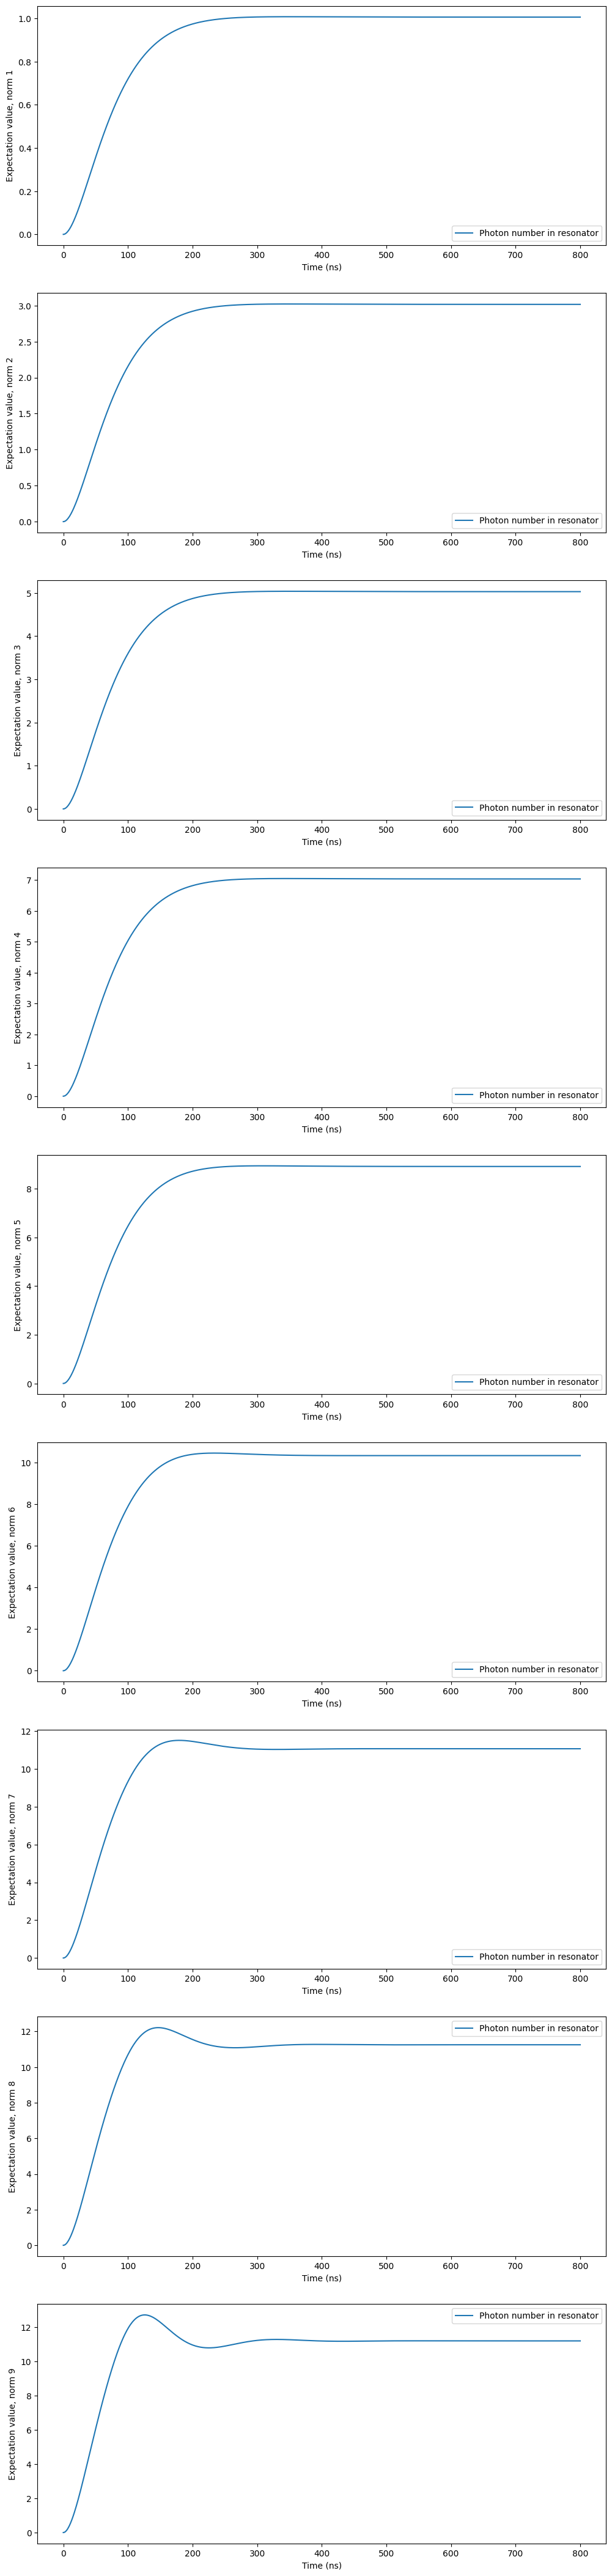

In [ ]:
# Explore effects of different drive powers on the system

norm = 1
N_plots = 10
plt.figure(figsize=(12, 60))

for i in range(1, N_plots):
    HD = np.sqrt(norm*drive_power) * (a + a.dag())
    H = H0 + HD
    tlist = np.linspace(0, 800, 800)  # Time from 0 to 800 ns

    # Calculate the steady state
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]
    norm += 2

    plt.subplot(N_plots, 1, i)
    plt.plot(tlist, expectation_values[0], label='Photon number in resonator')
    plt.xlabel('Time (ns)')
    plt.ylabel(f'Expectation value, norm {i}')
    plt.legend()


In [ ]:
# Define metrics to analyse pulse effectiveness

def find_steady_state_time(tlist, photon_number, threshold=1e-3, window_size=500):
    photon_number = np.array(photon_number)
    tlist = np.array(tlist)

    for i in range(len(photon_number) - window_size):
        window = photon_number[i:i + window_size]
        if np.max(window) - np.min(window) < threshold:
            return tlist[i]
    
    return None

def find_cavity_reset_time(tlist, photon_number, threshold=1e-3):
    photon_number = np.array(photon_number[5000:])
    tlist = np.array(tlist)

    below_threshold = np.where(photon_number <= threshold)[0]
    if len(below_threshold) > 0:
        return tlist[below_threshold[0] + 5000] - 500
    else:
        return None

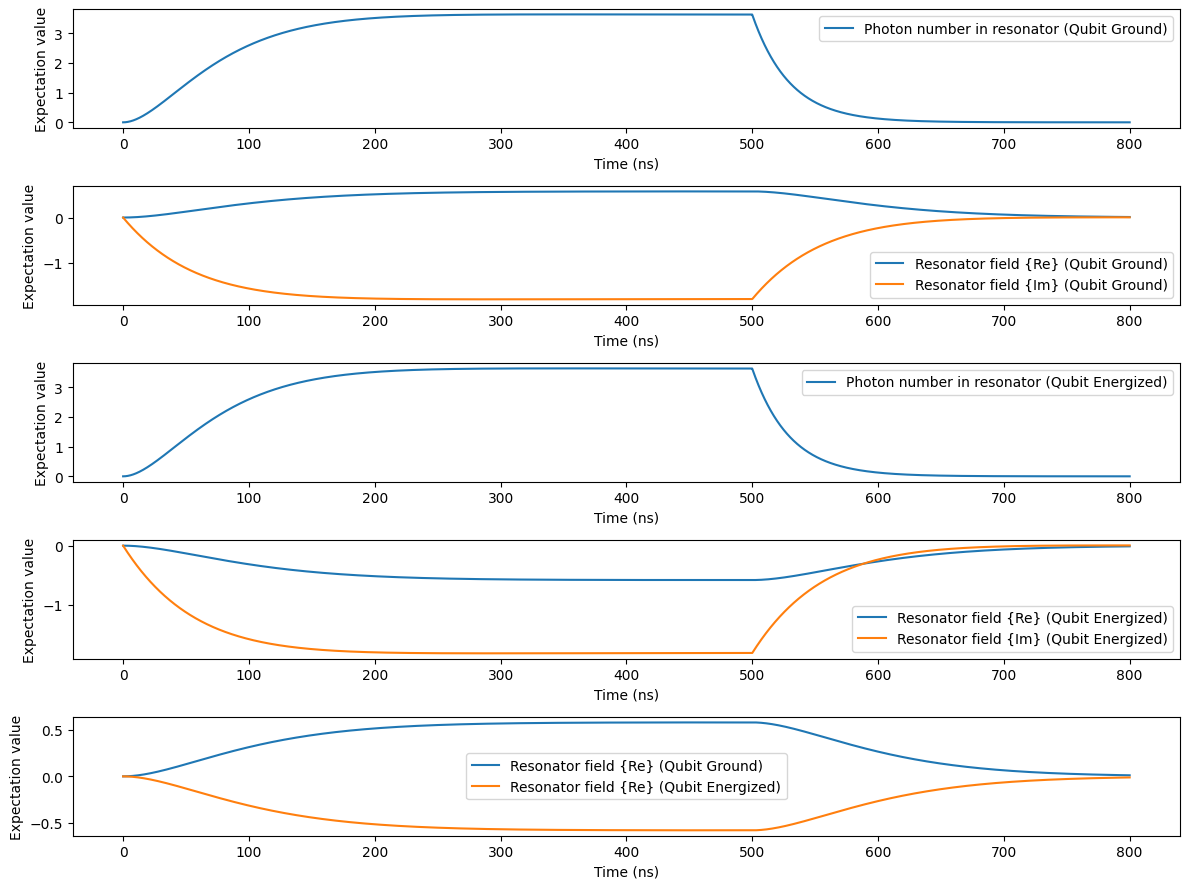

In [ ]:
# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000) 
expectations_g = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e = mesolve(H, psi1, tlist, c_ops, e_ops)


# Extract the expectation values
expectation_values_g = [expectations_g.expect[i] for i in range(len(e_ops))]
expectation_values_e = [expectations_e.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(5, 1, 1)
plt.plot(tlist, expectation_values_g[0], label='Photon number in resonator (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.imag(expectation_values_g[1]), label='Resonator field {Im} (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(tlist, expectation_values_e[0], label='Photon number in resonator (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.plot(tlist, np.imag(expectation_values_e[1]), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
# Determine steady state time and reset time for a rectangle pulse
steady_state_time = find_steady_state_time(tlist, expectation_values_g[0])
reset_time = find_cavity_reset_time(tlist, expectation_values_g[0])
print(f"Rectangle Pulse Steady state duration: {steady_state_time} ns")
print(f"Rectangle Pulse Cavity reset duration: {reset_time} ns")

Rectangle Pulse Steady state duration: 321.44018002250283 ns
Rectangle Pulse Cavity reset duration: 243.79297412176527 ns


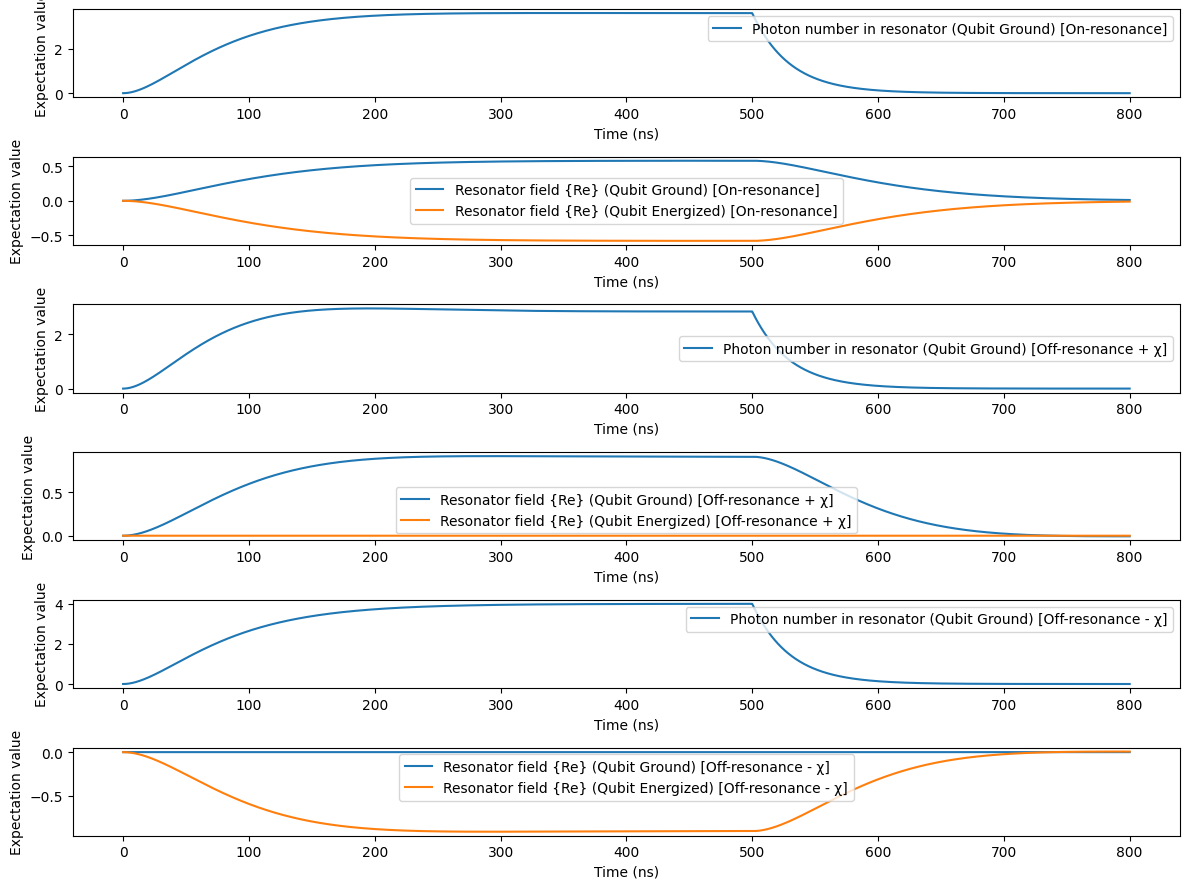

In [ ]:
# Testing the resonator field with different drive frequencies (off-resonance shifted by chi)

wd = wr
H0 = (wr - wd - chi * sz) * a.dag() * a

# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_g_res = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e_res = mesolve(H, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_g_res = [expectations_g_res.expect[i] for i in range(len(e_ops))]
expectation_values_e_res = [expectations_e_res.expect[i] for i in range(len(e_ops))]


wd = wr + chi
H0 = (wr - wd - chi * sz) * a.dag() * a
H = [H0, HD]
expectations_g_plus = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e_plus = mesolve(H, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_g_plus = [expectations_g_plus.expect[i] for i in range(len(e_ops))]
expectation_values_e_plus = [expectations_e_plus.expect[i] for i in range(len(e_ops))]


wd = wr - chi
H0 = (wr - wd - chi * sz) * a.dag() * a
H = [H0, HD]
expectations_g_minus = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e_minus = mesolve(H, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_g_minus = [expectations_g_minus.expect[i] for i in range(len(e_ops))]
expectation_values_e_minus = [expectations_e_minus.expect[i] for i in range(len(e_ops))]


# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(6, 1, 1)
plt.plot(tlist, expectation_values_g_res[0], label='Photon number in resonator (Qubit Ground) [On-resonance]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(tlist, np.real(expectation_values_g_res[1]), label='Resonator field {Re} (Qubit Ground) [On-resonance]')
plt.plot(tlist, np.real(expectation_values_e_res[1]), label='Resonator field {Re} (Qubit Energized) [On-resonance]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(tlist, expectation_values_g_plus[0], label='Photon number in resonator (Qubit Ground) [Off-resonance + χ]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 4)    
plt.plot(tlist, np.real(expectation_values_g_plus[1]), label='Resonator field {Re} (Qubit Ground) [Off-resonance + χ]')
plt.plot(tlist, np.real(expectation_values_e_plus[1]), label='Resonator field {Re} (Qubit Energized) [Off-resonance + χ]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(tlist, expectation_values_g_minus[0], label='Photon number in resonator (Qubit Ground) [Off-resonance - χ]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(tlist, np.real(expectation_values_g_minus[1]), label='Resonator field {Re} (Qubit Ground) [Off-resonance - χ]')
plt.plot(tlist, np.real(expectation_values_e_minus[1]), label='Resonator field {Re} (Qubit Energized) [Off-resonance - χ]')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()    

plt.tight_layout()
plt.show()

Steady state is close to coherent state for Ground Qubit: True
Steady state is close to coherent state for Excited Qubit: True
Steady state is close to coherent state for Superposition Qubit: False


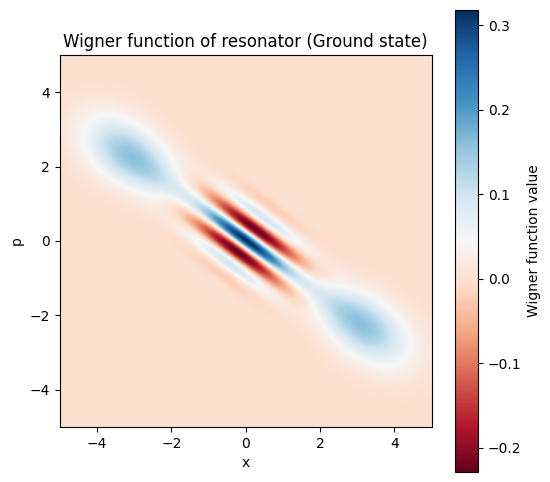

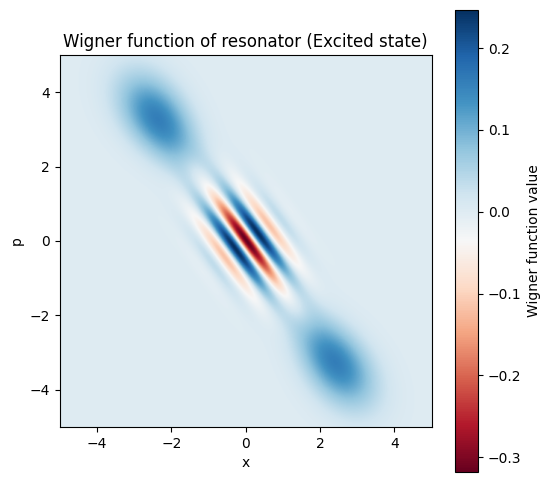

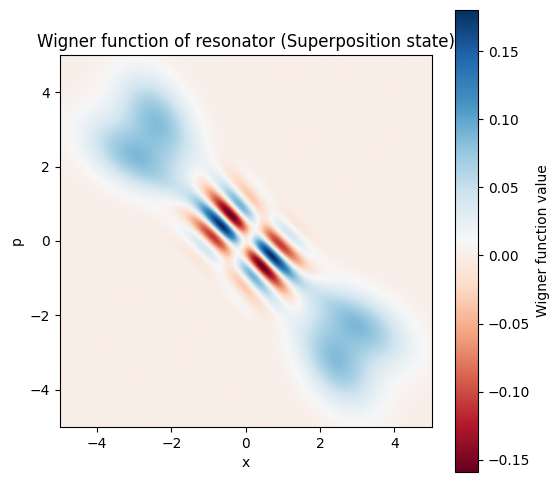

In [ ]:
# Explore the steady state of the resonator field for different qubit states

norm = 3.6
drive_amp = np.sqrt(norm * drive_power) 
HD = drive_amp *(a + a.dag())
H = H0 + HD

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000) 
states_g = mesolve(H, psi0, tlist, c_ops)
states_e = mesolve(H, psi1, tlist, c_ops)
states_s = mesolve(H, psis, tlist, c_ops)

xvec = np.linspace(-5, 5, 500)

expect_a_g = expect(a, states_g.states[-1])
expect_n_g = expect((a.dag() * a), states_g.states[-1])
is_close_g = np.isclose(abs(expect_a_g)**2, expect_n_g)
print("Steady state is close to coherent state for Ground Qubit:", is_close_g)

expect_a_e = expect(a, states_e.states[-1])
expect_n_e = expect((a.dag() * a), states_e.states[-1])
is_close_e = np.isclose(abs(expect_a_e)**2, expect_n_e)
print("Steady state is close to coherent state for Excited Qubit:", is_close_e)

expect_a_s = expect(a, states_s.states[-1])
expect_n_s = expect((a.dag() * a), states_s.states[-1])
is_close_s = np.isclose(abs(expect_a_s)**2, expect_n_s)
print("Steady state is close to coherent state for Superposition Qubit:", is_close_s)

W_g = wigner(states_g.states[-1], xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_g, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of qubit-resonator (Ground state)")
plt.xlabel('x')
plt.ylabel('p') 

W_e = wigner(states_e.states[-1], xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_e, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of qubit-resonator (Excited state)")
plt.xlabel('x')
plt.ylabel('p')

W_s = wigner(states_s.states[-1], xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_s, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of qubit-resonator (Superposition state)")
plt.xlabel('x')
plt.ylabel('p') 

plt.show()

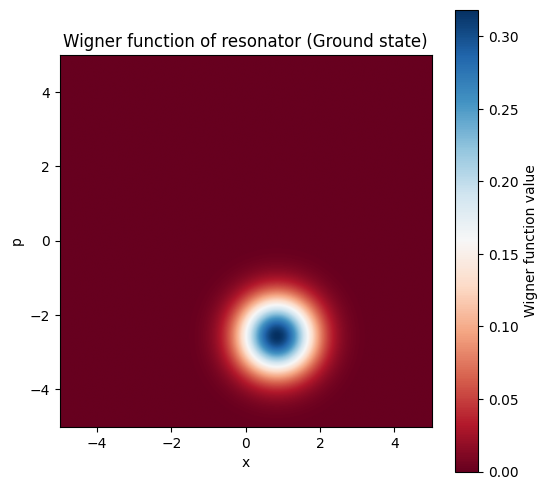

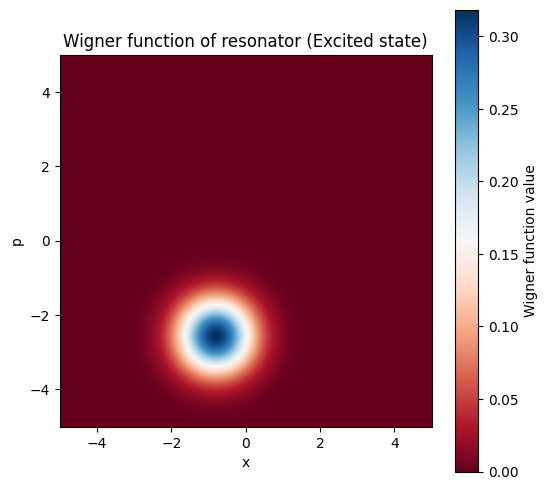

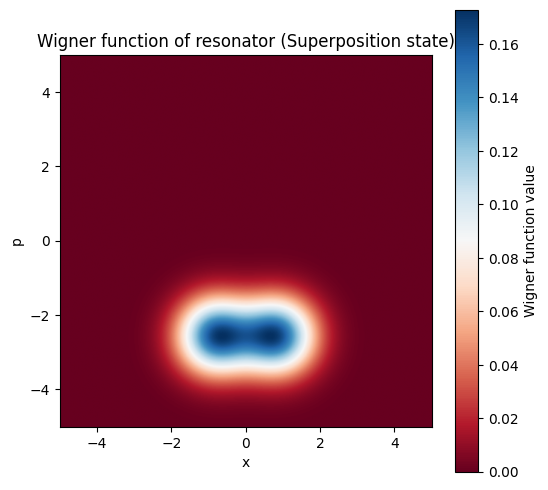

In [35]:
state_res_g = states_g.states[-1].ptrace(0)
state_res_e = states_e.states[-1].ptrace(0)
state_res_s = states_s.states[-1].ptrace(0)

xvec = np.linspace(-5, 5, 500)

W_g = wigner(state_res_g, xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_g, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of resonator (Ground state)")
plt.xlabel('x')
plt.ylabel('p') 

W_e = wigner(state_res_e, xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_e, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of resonator (Excited state)")
plt.xlabel('x')
plt.ylabel('p')

W_s = wigner(state_res_s, xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_s, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of resonator (Superposition state)")
plt.xlabel('x')
plt.ylabel('p') 

plt.show()

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


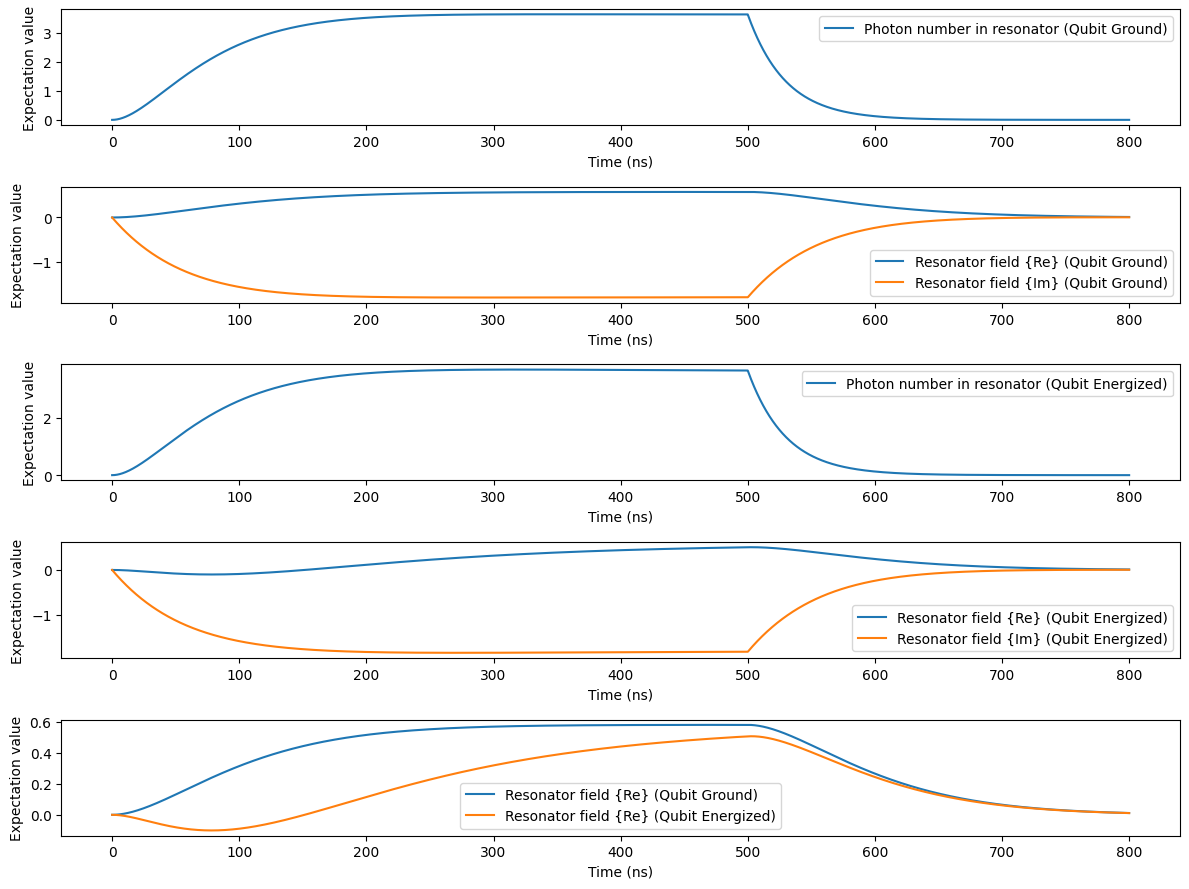

In [ ]:
# Factor in effects of qubit relaxation

# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

c_ops = [np.sqrt(k) * a, np.sqrt(gamma) * q, np.sqrt(gamma) * sz]  # Resonator decay and qubit decay
# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_g = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e = mesolve(H, psi1, tlist, c_ops, e_ops)


# Extract the expectation values
expectation_values_g = [expectations_g.expect[i] for i in range(len(e_ops))]
expectation_values_e = [expectations_e.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(5, 1, 1)
plt.plot(tlist, expectation_values_g[0], label='Photon number in resonator (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.imag(expectation_values_g[1]), label='Resonator field {Im} (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(tlist, expectation_values_e[0], label='Photon number in resonator (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.plot(tlist, np.imag(expectation_values_e[1]), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


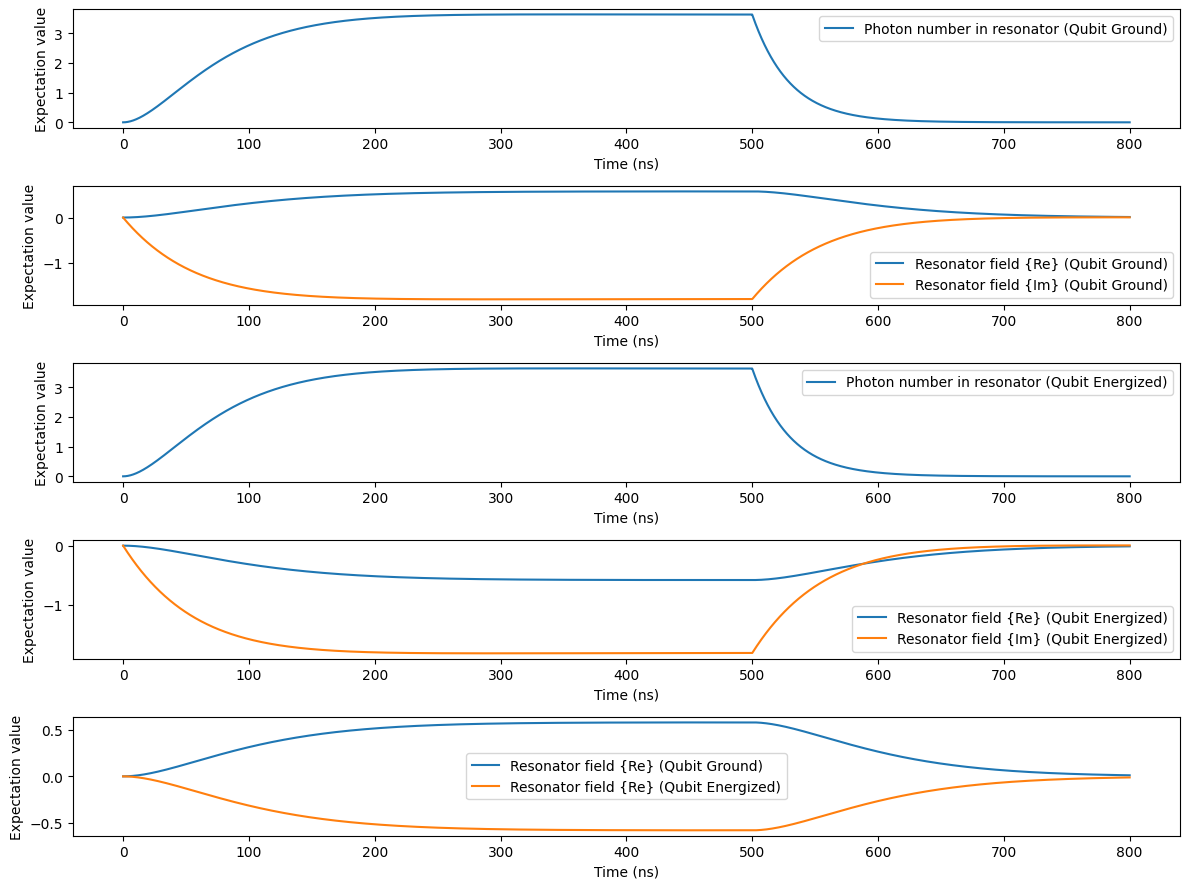

In [ ]:
# Factor in effects of qubit dephasing

# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

c_ops = [np.sqrt(k) * a, np.sqrt(gamma) * sz]  # Resonator decay and qubit decay
# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_g = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e = mesolve(H, psi1, tlist, c_ops, e_ops)


# Extract the expectation values
expectation_values_g = [expectations_g.expect[i] for i in range(len(e_ops))]
expectation_values_e = [expectations_e.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(5, 1, 1)
plt.plot(tlist, expectation_values_g[0], label='Photon number in resonator (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.imag(expectation_values_g[1]), label='Resonator field {Im} (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(tlist, expectation_values_e[0], label='Photon number in resonator (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.plot(tlist, np.imag(expectation_values_e[1]), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(tlist, np.real(expectation_values_g[1]), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.real(expectation_values_e[1]), label='Resonator field {Re} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define simulate functions for optimizing the ring-up and ring-down sequences

def simulate_populate(ringup_time, ringdown_time, ringup_norm, ringdown_norm):
    drive_norm = 3.6
    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse(t, args):
        if t<=ringup_time:
            return ringup_amp
        elif t <= ringup_time + ringdown_time:
            return ringdown_amp
        elif t <= 500:
            return drive_amp
        else:   
            return 0.0
        
    HD = [(a + a.dag()), drive_pulse]
    H = [H0, HD]

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

    return expectation_values

def simulate_reset(ringup_time, ringdown_time, ringup_norm, ringdown_norm):
    drive_norm = 3.6

    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = -np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse_rst(t, args):
        if t<=500:
            return drive_amp 
        elif t <= 500 + ringdown_time:
            return ringdown_amp
        elif t <= 500 + ringdown_time + ringup_time:
            return ringup_amp
        else:   
            return 0.0
        
    HD = [(a + a.dag()), drive_pulse_rst]
    H = [H0, HD]

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

    return expectation_values

In [ ]:
def analyze_response(tlist, n_t, tol=0.01, window=100):
    """
    Analyze photon response curve to compute settling time and overshoot.
    """
    steady_value = np.mean(n_t[5000-window:5000])
    
    # Settling time: first time it stays within tol of steady value
    for i in range(len(n_t) - window):
        window_segment = n_t[i:i + window]
        if np.all(np.abs(window_segment - steady_value) < tol * steady_value):
            settling_time = tlist[i]
            break
    else:
        settling_time = np.inf

    # Overshoot
    overshoot = np.max(n_t) - steady_value

    return settling_time, overshoot, steady_value

def compute_cost(settling_time, overshoot, w1=8.0, w2=2.0):
    return w1 * settling_time + w2 * overshoot

Optimal ring-up time: 65 ns, ring-down time: 26 ns, ring-up norm: 9, ring-down norm: 1.5 stabilization time: 246.530816352044 ns


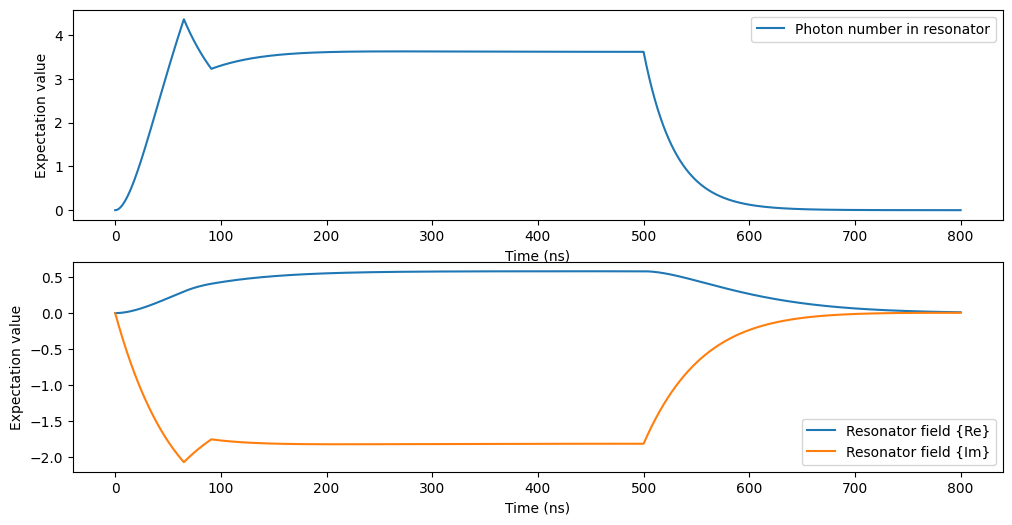

In [ ]:
# Optimise the ringup and ringdown times to arrive the fastest at steady state
ringup_times = np.arange(50, 70, 5) 
ringdown_times = np.arange(20, 30, 2)
ringup_norms = np.arange(4, 10, 1)  
ringdown_norms = np.arange(1, 3, 0.5)  
stabilization_times = []
for ringup in ringup_times:
    for ringdown in ringdown_times:
        for ringup_norm in ringup_norms:
            for ringdown_norm in ringdown_norms:
                # Extract the expectation values
                expectation_values = simulate_populate(ringup, ringdown, ringup_norm, ringdown_norm)
                # settling_time, overshoot, steady_val = analyze_response(tlist, expectation_values[0])
                # cost = compute_cost(settling_time, overshoot)
                # Find stabilization time
                stabilization_time = find_steady_state_time(tlist, expectation_values[0])
                stabilization_times.append((ringup, ringdown, ringup_norm, ringdown_norm, stabilization_time, expectation_values))
# Find the optimal ring-up and ring-down times
optimal = min(stabilization_times, key=lambda x: (x[4] is not None, x[4]))
print(f"Optimal ring-up time: {optimal[0]} ns, ring-down time: {optimal[1]} ns, ring-up norm: {optimal[2]}, ring-down norm: {optimal[3]} stabilization time: {optimal[4]} ns")
# Plot the results for the optimal ring-up and ring-down times
optimal_expectation_values = optimal[5]
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, optimal_expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, np.real(optimal_expectation_values[1]), label='Resonator field {Re}')
plt.plot(tlist, np.imag(optimal_expectation_values[1]), label='Resonator field {Im}')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.show()

Optimal ring-up time: 25 ns, ring-down time: 35 ns, ring-up norm: 1.0, ring-down norm: 9 reset time: 178.98487310913868 ns


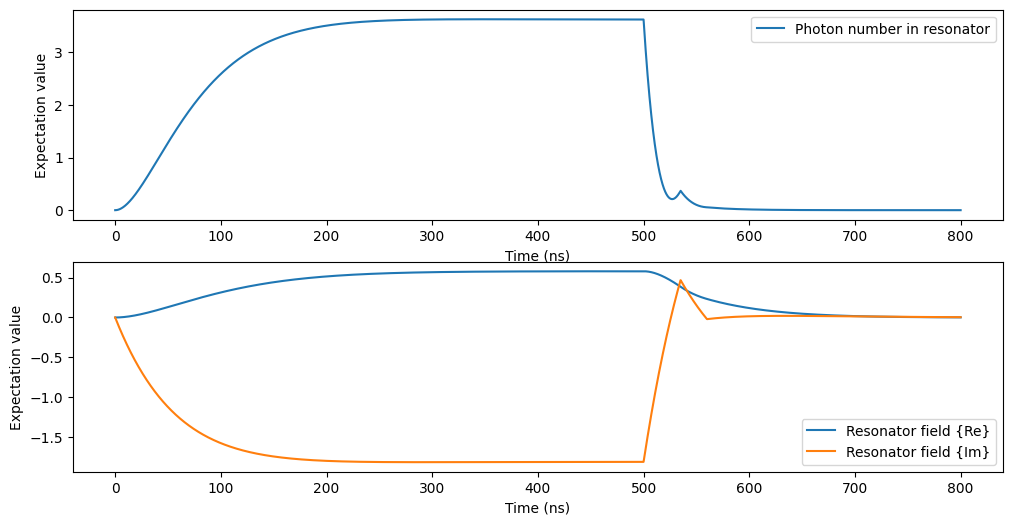

In [34]:
# Optimise the ringup and ringdown times to reset cavity fastest
ringup_times = np.arange(5, 40, 5)  
ringdown_times = np.arange(5, 40, 5)
ringup_norms = np.arange(1, 3, 0.5)  
ringdown_norms = np.arange(4, 10, 1) 
reset_times = []
for ringup in ringup_times:
    for ringdown in ringdown_times:
        for ringup_norm in ringup_norms:
            for ringdown_norm in ringdown_norms:
                # Extract the expectation values
                expectation_values = simulate_reset(ringup, ringdown, ringup_norm, ringdown_norm)

                # Find stabilization time
                reset_time = find_cavity_reset_time(tlist, expectation_values[0])
                reset_times.append((ringup, ringdown, ringup_norm, ringdown_norm, reset_time, expectation_values))
# Find the optimal ring-up and ring-down times
optimal = min(reset_times, key=lambda x: (x[4] is not None, x[4]))
print(f"Optimal ring-up time: {optimal[0]} ns, ring-down time: {optimal[1]} ns, ring-up norm: {optimal[2]}, ring-down norm: {optimal[3]} reset time: {optimal[4]} ns")
# Plot the results for the optimal ring-up and ring-down times
optimal_expectation_values = optimal[5]
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, optimal_expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, np.real(optimal_expectation_values[1]), label='Resonator field {Re}')
plt.plot(tlist, np.imag(optimal_expectation_values[1]), label='Resonator field {Im}')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.show()

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


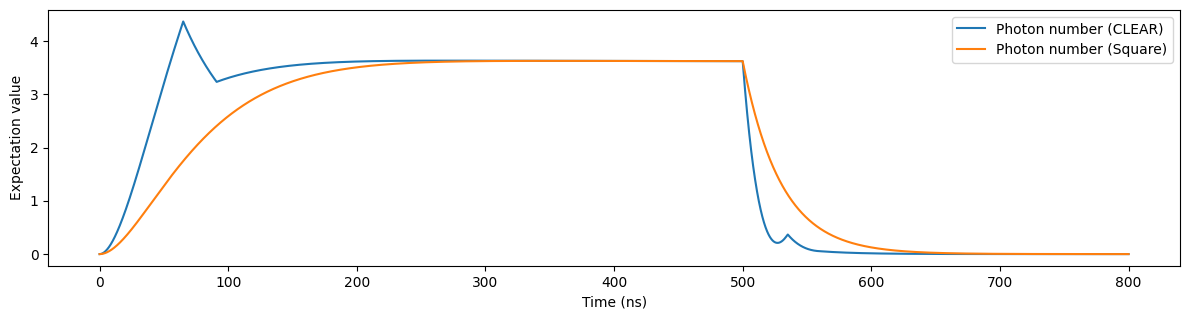

In [ ]:
# Full CLEAR signal and photon response using optimal ring-up and ring-down times
drive_power = 4.984375000000001e-05 * 2 * np.pi

ringup1_norm = 9
ringdown1_norm = 1.5
ringup1_amp = np.sqrt(ringup1_norm * drive_power)  # Amplitude of the ring-up pulse
ringdown1_amp = np.sqrt(ringdown1_norm * drive_power)  # Amplitude of the ring-down pulse

ringup2_norm = 1
drive_norm = 3.6
ringdown2_norm = 9
ringup2_amp = np.sqrt(ringup2_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown2_amp = -np.sqrt(ringdown2_norm * drive_power)  # Amplitude of the ring-down pulse

optimal_ringup1_time = 65
optimal_ringdown1_time = 26
optimal_ringup2_time = 25
optimal_ringdown2_time = 35


def CLEAR_pulse(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp 
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp
    elif t <= 500:
        return drive_amp
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp 
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp
    else:   
        return 0.0

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD_CLEAR = [(a + a.dag()), CLEAR_pulse]
H_CLEAR = [H0, HD_CLEAR]

HD_drive = [(a + a.dag()), drive_pulse]
H_drive = [H0, HD_drive]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_CLEAR = mesolve(H_CLEAR, psi0, tlist, c_ops, e_ops)
expectations_square = mesolve(H_drive, psi0, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_CLEAR = [expectations_CLEAR.expect[i] for i in range(len(e_ops))]
expectation_values_square = [expectations_square.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, expectation_values_CLEAR[0], label='Photon number (CLEAR)')
plt.plot(tlist, expectation_values_square[0], label='Photon number (Square)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

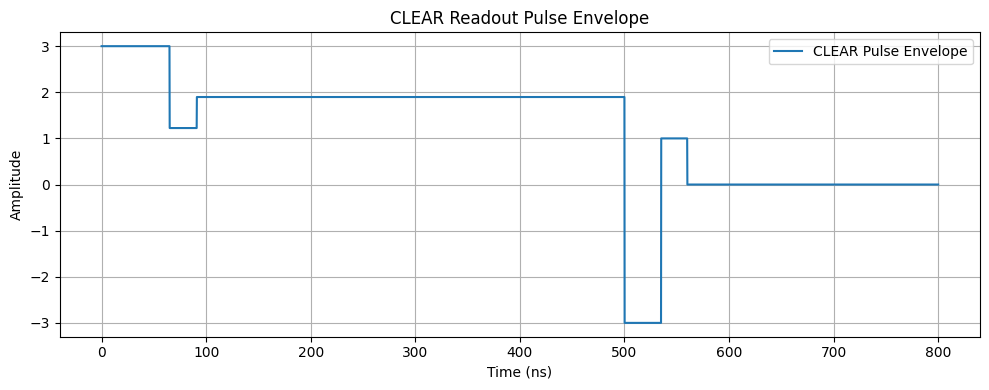

In [ ]:
# Plot the CLEAR pulse envelope

envelope = [CLEAR_pulse(t, None) / np.sqrt(drive_power) for t in tlist]
plt.figure(figsize=(10, 4))
plt.plot(tlist, envelope, label='CLEAR Pulse Envelope')
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("CLEAR Readout Pulse Envelope")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
# Determine steady state time and reset time for a CLEAR pulse
steady_state_time_CLEAR = find_steady_state_time(tlist, expectation_values_CLEAR[0])
reset_time_CLEAR = find_cavity_reset_time(tlist, expectation_values_CLEAR[0])
print(f"CLEAR Pulse Steady state duration: {steady_state_time_CLEAR} ns")
print(f"CLEAR Pulse Cavity reset duration: {reset_time_CLEAR} ns")

# Determine steady state time and reset time for a rectangle pulse
steady_state_time_square = find_steady_state_time(tlist, expectation_values_square[0])
reset_time_square = find_cavity_reset_time(tlist, expectation_values_square[0])
print(f"Square Pulse Steady state duration: {steady_state_time_square} ns") 
print(f"Square Pulse Cavity reset duration: {reset_time_square} ns")

CLEAR Pulse Steady state duration: 246.530816352044 ns
CLEAR Pulse Cavity reset duration: 178.98487310913868 ns
Square Pulse Steady state duration: 321.44018002250283 ns
Square Pulse Cavity reset duration: 243.79297412176527 ns


### Simulating the IQ response to readout pulse

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


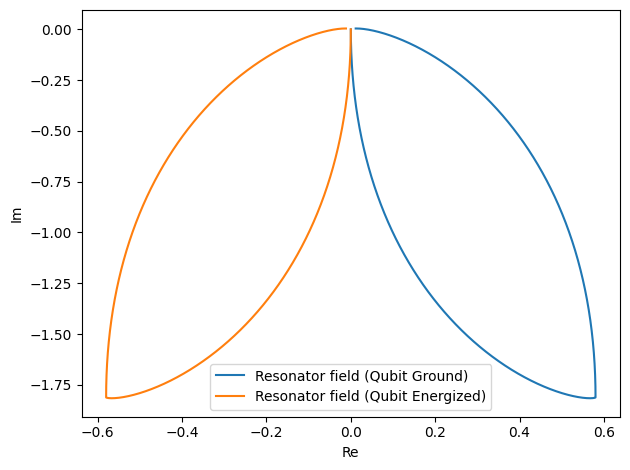

In [25]:
# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

c_ops = [np.sqrt(k) * a]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_g = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e = mesolve(H, psi1, tlist, c_ops, e_ops)


# Extract the expectation values
expectation_values_g = [expectations_g.expect[i] for i in range(len(e_ops))]
expectation_values_e = [expectations_e.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure()

plt.plot(np.real(expectation_values_g[1]), np.imag(expectation_values_g[1]), label='Resonator field (Qubit Ground)')
plt.plot(np.real(expectation_values_e[1]), np.imag(expectation_values_e[1]), label='Resonator field (Qubit Energized)')
plt.xlabel('Re')
plt.ylabel('Im')
plt.legend()

plt.tight_layout()
plt.show()

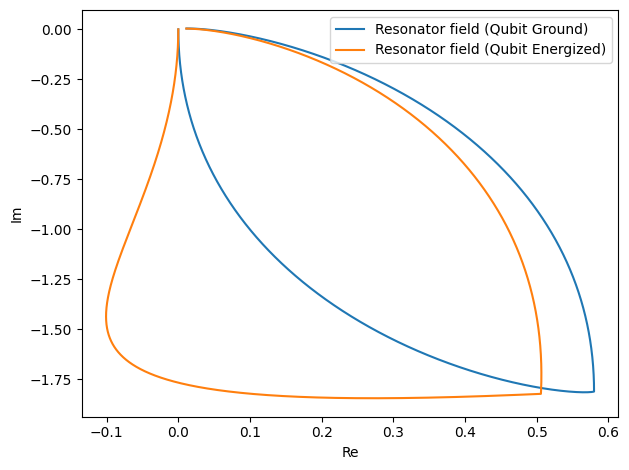

In [26]:
# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

c_ops = [np.sqrt(k) * a, np.sqrt(gamma) * q]  # Resonator decay and qubit decay

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_g = mesolve(H, psi0, tlist, c_ops, e_ops)
expectations_e = mesolve(H, psi1, tlist, c_ops, e_ops)


# Extract the expectation values
expectation_values_g = [expectations_g.expect[i] for i in range(len(e_ops))]
expectation_values_e = [expectations_e.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure()

plt.plot(np.real(expectation_values_g[1]), np.imag(expectation_values_g[1]), label='Resonator field (Qubit Ground)')
plt.plot(np.real(expectation_values_e[1]), np.imag(expectation_values_e[1]), label='Resonator field (Qubit Energized)')
plt.xlabel('Re')
plt.ylabel('Im')
plt.legend()

plt.tight_layout()
plt.show()

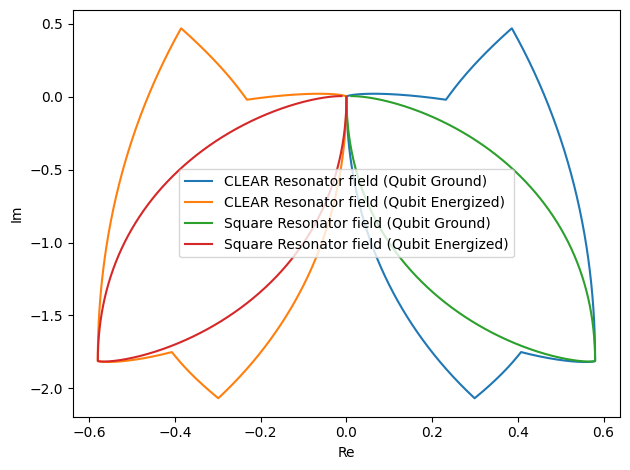

In [ ]:
# Full CLEAR signal and photon response
drive_power = 4.984375000000001e-05 * 2 * np.pi

ringup1_norm = 9
ringdown1_norm = 1.5
ringup1_amp = np.sqrt(ringup1_norm * drive_power)  # Amplitude of the ring-up pulse
ringdown1_amp = np.sqrt(ringdown1_norm * drive_power)  # Amplitude of the ring-down pulse

ringup2_norm = 1
drive_norm = 3.6
ringdown2_norm = 9
ringup2_amp = np.sqrt(ringup2_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown2_amp = -np.sqrt(ringdown2_norm * drive_power)  # Amplitude of the ring-down pulse

optimal_ringup1_time = 65
optimal_ringdown1_time = 26
optimal_ringup2_time = 25
optimal_ringdown2_time = 35


def CLEAR_pulse(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp 
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp
    elif t <= 500:
        return drive_amp
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp 
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp
    else:   
        return 0.0

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD_CLEAR = [(a + a.dag()), CLEAR_pulse]
H_CLEAR = [H0, HD_CLEAR]


HD_drive = [(a + a.dag()), drive_pulse]
H_drive = [H0, HD_drive]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_CLEAR_g = mesolve(H_CLEAR, psi0, tlist, c_ops, e_ops)
expectations_square_g = mesolve(H_drive, psi0, tlist, c_ops, e_ops)
expectations_CLEAR_e = mesolve(H_CLEAR, psi1, tlist, c_ops, e_ops)
expectations_square_e = mesolve(H_drive, psi1, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_CLEAR_g = [expectations_CLEAR_g.expect[i] for i in range(len(e_ops))]
expectation_values_square_g = [expectations_square_g.expect[i] for i in range(len(e_ops))]
expectation_values_CLEAR_e = [expectations_CLEAR_e.expect[i] for i in range(len(e_ops))]
expectation_values_square_e = [expectations_square_e.expect[i] for i in range(len(e_ops))]


# Plot the results
plt.figure()

plt.plot(np.real(expectation_values_CLEAR_g[1]), np.imag(expectation_values_CLEAR_g[1]), label='CLEAR Resonator field (Qubit Ground)')
plt.plot(np.real(expectation_values_CLEAR_e[1]), np.imag(expectation_values_CLEAR_e[1]), label='CLEAR Resonator field (Qubit Energized)')
plt.plot(np.real(expectation_values_square_g[1]), np.imag(expectation_values_square_g[1]), label='Square Resonator field (Qubit Ground)')
plt.plot(np.real(expectation_values_square_e[1]), np.imag(expectation_values_square_e[1]), label='Square Resonator field (Qubit Energized)')
plt.xlabel('Re')
plt.ylabel('Im')
plt.legend()

plt.tight_layout()
plt.show()

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:526: FutureWarning: "nsubsteps" is now replaced by "dt" in options:
Use `options={"dt": 0.001}`
The given value of "nsubsteps" is ignored in this call.
  warnings.warn(
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:553: FutureWarning: The "store_measurement" parameter is now an options:
Use `options={"store_measurement": False / True}`
  warnings.warn(


12.0%. Run time: 395.30s. Est. time left: 00:00:48:18
20.0%. Run time: 786.13s. Est. time left: 00:00:52:24
32.0%. Run time: 1373.69s. Est. time left: 00:00:48:39
40.0%. Run time: 1770.48s. Est. time left: 00:00:44:15
52.0%. Run time: 2357.13s. Est. time left: 00:00:36:15
60.0%. Run time: 2746.72s. Est. time left: 00:00:30:31
72.0%. Run time: 3334.71s. Est. time left: 00:00:21:36
80.0%. Run time: 3728.22s. Est. time left: 00:00:15:32
92.0%. Run time: 4316.81s. Est. time left: 00:00:06:15
100.0%. Run time: 4706.68s. Est. time left: 00:00:00:00
Total run time: 4900.19s
12.0%. Run time: 387.61s. Est. time left: 00:00:47:22
20.0%. Run time: 782.83s. Est. time left: 00:00:52:11
32.0%. Run time: 1366.44s. Est. time left: 00:00:48:23
40.0%. Run time: 1756.91s. Est. time left: 00:00:43:55
52.0%. Run time: 2341.30s. Est. time left: 00:00:36:01
60.0%. Run time: 2732.66s. Est. time left: 00:00:30:21
72.0%. Run time: 3329.57s. Est. time left: 00:00:21:34
80.0%. Run time: 3739.45s. Est. time left: 

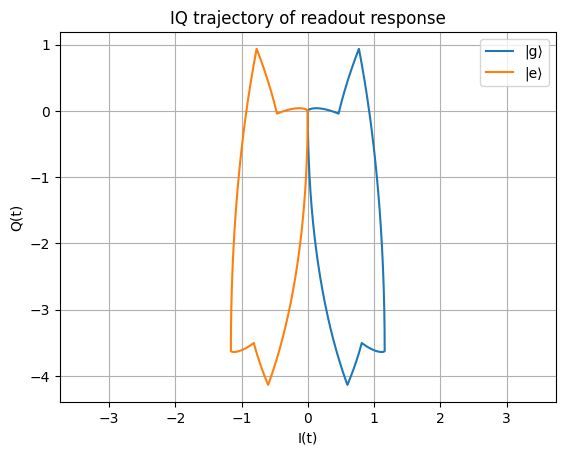

In [ ]:
# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
N_traj = 25  # Number of trajectories for stochastic simulation
# res_g = mesolve(H_CLEAR, psi0, tlist, c_ops,  [a + a.dag(), -1j * (a - a.dag())])
# res_e = mesolve(H_CLEAR, psi1, tlist, c_ops,  [a + a.dag(), -1j * (a - a.dag())])

res_g = smesolve(H_CLEAR, psi0, tlist,
        c_ops=[np.sqrt(k) * a],
        sc_ops=[np.sqrt(gamma) * sz],
        e_ops=[a + a.dag(), -1j * (a - a.dag())],
        ntraj=N_traj,
        store_measurement=True,
        heterodyne=True)
res_e = smesolve(H_CLEAR, psi1, tlist,
        c_ops=[np.sqrt(k) * a],
        sc_ops=[np.sqrt(gamma) * sz],
        e_ops=[a + a.dag(), -1j * (a - a.dag())],
        ntraj=N_traj,
        store_measurement=True,
        heterodyne=True)

# Extract the expectation values
I_g, Q_g = res_g.expect
I_e, Q_e = res_e.expect

plt.figure()
plt.plot(I_g, Q_g, label='|g⟩')
plt.plot(I_e, Q_e, label='|e⟩')
plt.xlabel("I(t)")
plt.ylabel("Q(t)")
plt.title("IQ trajectory of readout response")
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()

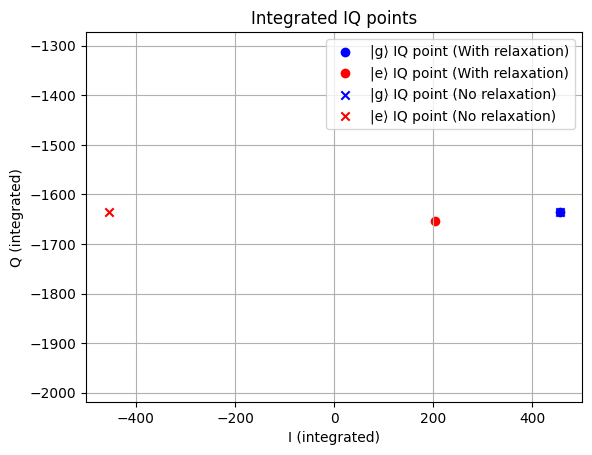

In [32]:
# First, define rectangle pulse as the drive pulse
norm = 3.6
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD = [(a + a.dag()), drive_pulse]
H = [H0, HD]

e_ops = [a + a.dag(), -1j * (a - a.dag())]  # Measurement operators for IQ points
c_ops = [np.sqrt(k) * a, np.sqrt(gamma) * q]  # Resonator decay and qubit decay

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
I_g, Q_g = mesolve(H, psi0, tlist, c_ops, e_ops).expect
I_e, Q_e = mesolve(H, psi1, tlist, c_ops, e_ops).expect

I_g_avg = np.trapezoid(I_g[:5000], tlist[:5000])
Q_g_avg = np.trapezoid(Q_g[:5000], tlist[:5000])

I_e_avg = np.trapezoid(I_e[:5000], tlist[:5000])
Q_e_avg = np.trapezoid(Q_e[:5000], tlist[:5000])

c_ops = [np.sqrt(k) * a]  # Resonator decay and qubit decay

# Calculate the expectation values of the measurement operators
I_g_norm, Q_g_norm = mesolve(H, psi0, tlist, c_ops, e_ops).expect
I_e_norm, Q_e_norm = mesolve(H, psi1, tlist, c_ops, e_ops).expect

I_g_avg_norm = np.trapezoid(I_g_norm[:5000], tlist[:5000])
Q_g_avg_norm = np.trapezoid(Q_g_norm[:5000], tlist[:5000])

I_e_avg_norm = np.trapezoid(I_e_norm[:5000], tlist[:5000])
Q_e_avg_norm = np.trapezoid(Q_e_norm[:5000], tlist[:5000])


plt.figure()
plt.scatter(I_g_avg, Q_g_avg, label='|g⟩ IQ point (With relaxation)', color='blue')
plt.scatter(I_e_avg, Q_e_avg, label='|e⟩ IQ point (With relaxation)', color='red')
plt.scatter(I_g_avg_norm, Q_g_avg_norm, label='|g⟩ IQ point (No relaxation)', color='blue', marker='x')
plt.scatter(I_e_avg_norm, Q_e_avg_norm, label='|e⟩ IQ point (No relaxation)', color='red', marker='x')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("Integrated IQ points")
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()

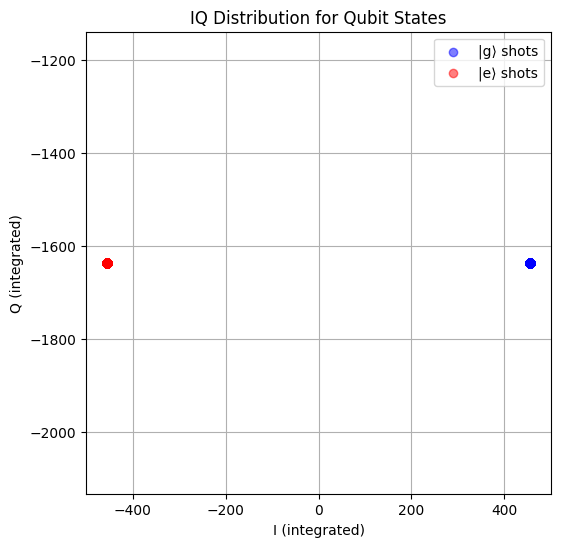

In [47]:
# Simulate sampling to build up IQ distribution

nshots = 200           # number of trajectories (shots)

def run_shots(psi0, label):
    I_vals = []
    Q_vals = []
    for _ in range(nshots):
        traj = mcsolve(H, psi0, tlist, c_ops, [a + a.dag(), -1j * (a - a.dag())], ntraj=1, progress_bar=False)
        I_t = traj.expect[0]
        Q_t = traj.expect[1]
        # Time-integrated IQ
        I_int = np.trapezoid(I_t[:5000], tlist[:5000])
        Q_int = np.trapezoid(Q_t[:5000], tlist[:5000])
        I_vals.append(I_int)
        Q_vals.append(Q_int)
    return np.array(I_vals), np.array(Q_vals)

# Run for both states
I_g, Q_g = run_shots(psi0, "|g>")
I_e, Q_e = run_shots(psi1, "|e>")

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

IQ_g = np.vstack([I_g, Q_g]).T
IQ_e = np.vstack([I_e, Q_e]).T

# Stack all IQs and labels
IQ_all = np.vstack([IQ_g, IQ_e])
labels = np.array([0]*len(IQ_g) + [1]*len(IQ_e))  # 0 for |g⟩, 1 for |e⟩

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(IQ_all, labels)
preds = lda.predict(IQ_all)

# Readout fidelity
fidelity = accuracy_score(labels, preds)
print(f"Readout fidelity: {fidelity:.4f}")

# Mean vectors
mu_g = np.mean(IQ_g, axis=0)
mu_e = np.mean(IQ_e, axis=0)

# Difference vector (signal direction)
d = mu_e - mu_g
d_unit = d / np.linalg.norm(d)

# Project all IQ points onto signal axis
proj_g = IQ_g @ d_unit
proj_e = IQ_e @ d_unit

# Compute noise variance (assume equal noise for both classes)
sigma2 = 0.5 * (np.var(proj_g) + np.var(proj_e))

# Compute SNR
snr = (np.linalg.norm(mu_e - mu_g) ** 2) / sigma2
print(f"SNR of readout: {snr:.2f}")

Readout fidelity: 0.9999
SNR of readout: 11.27


In [12]:
def estimate_qnd_violation(psi0, label):
    pop_g = []
    for _ in range(nshots):
        traj = mcsolve(H, psi0, tlist, c_ops, [], ntraj=1, progress_bar=None)
        final_state = traj.states[-1]
        rho = final_state.ptrace(1)  # trace out resonator
        p_g = expect(basis(2, 0) * basis(2, 0).dag(), rho)
        pop_g.append(p_g)
    return np.mean(pop_g)

p_g_after_g = estimate_qnd_violation(psi0, '|g⟩ init')
p_g_after_e = estimate_qnd_violation(psi1, '|e⟩ init')
print(f"Qubit remains in |g⟩ after measurement (started in |g⟩): {p_g_after_g:.4f}")
print(f"Qubit remains in |e⟩ after measurement (started in |e⟩): {1 - p_g_after_e:.4f}")

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:479: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Total run time:   1.40s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.82s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.10s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.33s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.96s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.14s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.96s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.71s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.59s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.50s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.39s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.38s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.49s
100.0%. Run time:   0.00s. E

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:479: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


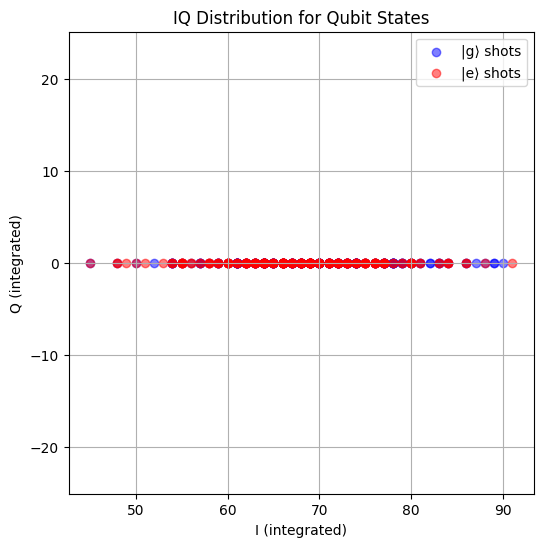

In [44]:
# Measurement operator: heterodyne = a
# It gives complex signal: Re(j(t)) ~ I(t), Im(j(t)) ~ Q(t)

# Storage for IQ points
nshots = 200
IQ_g = []
IQ_e = []

def run_photocurrent_measurements(psi, label):
    IQ_data = []
    for _ in range(nshots):
        result = mcsolve(
            H, psi, tlist,
            c_ops=c_ops,
            e_ops=[a],
            ntraj=1,
            progress_bar = False
        )
        # Extract the measurement signal j(t)
        j_t = result.photocurrent[0] # shape: (len(tlist), )
        IQ_val = np.trapezoid(j_t, tlist[:-1])  # complex value: integrated heterodyne signal
        IQ_data.append(IQ_val)
    return np.array(IQ_data)

# Run simulations
IQ_g = run_photocurrent_measurements(psi0, "|g⟩")
IQ_e = run_photocurrent_measurements(psi1, "|e⟩")

# Separate I/Q components
I_g, Q_g = np.real(IQ_g), np.imag(IQ_g)
I_e, Q_e = np.real(IQ_e), np.imag(IQ_e)

plt.figure(figsize=(6, 6))
plt.scatter(I_g, Q_g, color='blue', alpha=0.5, label='|g⟩ shots')
plt.scatter(I_e, Q_e, color='red', alpha=0.5, label='|e⟩ shots')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("IQ Distribution for Qubit States")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

